In [2]:
%matplotlib inline 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from timeit import default_timer as timers

In [4]:
# load the data
df = pd.read_csv('sunspot_data.csv', delimiter=',', na_values=['-1'])
df.dataframeName = 'sunspot_data.csv'
df.head(-5)

,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,0,1818,1,1,1818.001,NaN,NaN,0,1
1,1,1818,1,2,1818.004,NaN,NaN,0,1
2,2,1818,1,3,1818.007,NaN,NaN,0,1
3,3,1818,1,4,1818.010,NaN,NaN,0,1
4,4,1818,1,5,1818.012,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...
73708,73708,2019,10,22,2019.807,0.0,0.0,31,0
73709,73709,2019,10,23,2019.810,0.0,0.0,29,0
73710,73710,2019,10,24,2019.812,0.0,0.0,27,0
73711,73711,2019,10,25,2019.815,0.0,0.0,31,0


In [5]:
del(df['Unnamed: 0'])
df.columns = ['year', 'month', 'day', 'fraction','sunspots', 'sdt', 'obs','indicator']

df['time']=df[['year', 'month', 'day']].apply(lambda s: pd.datetime(*s),axis = 1)
df.index = df['time']

/var/folders/_c/6f13vy4j7y35_jqznz785dz40000gn/T/ipykernel_5496/1647037689.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df['time']=df[['year', 'month', 'day']].apply(lambda s: pd.datetime(*s),axis = 1)


In [6]:
df['sunspots'].interpolate(method='linear', inplace=True)

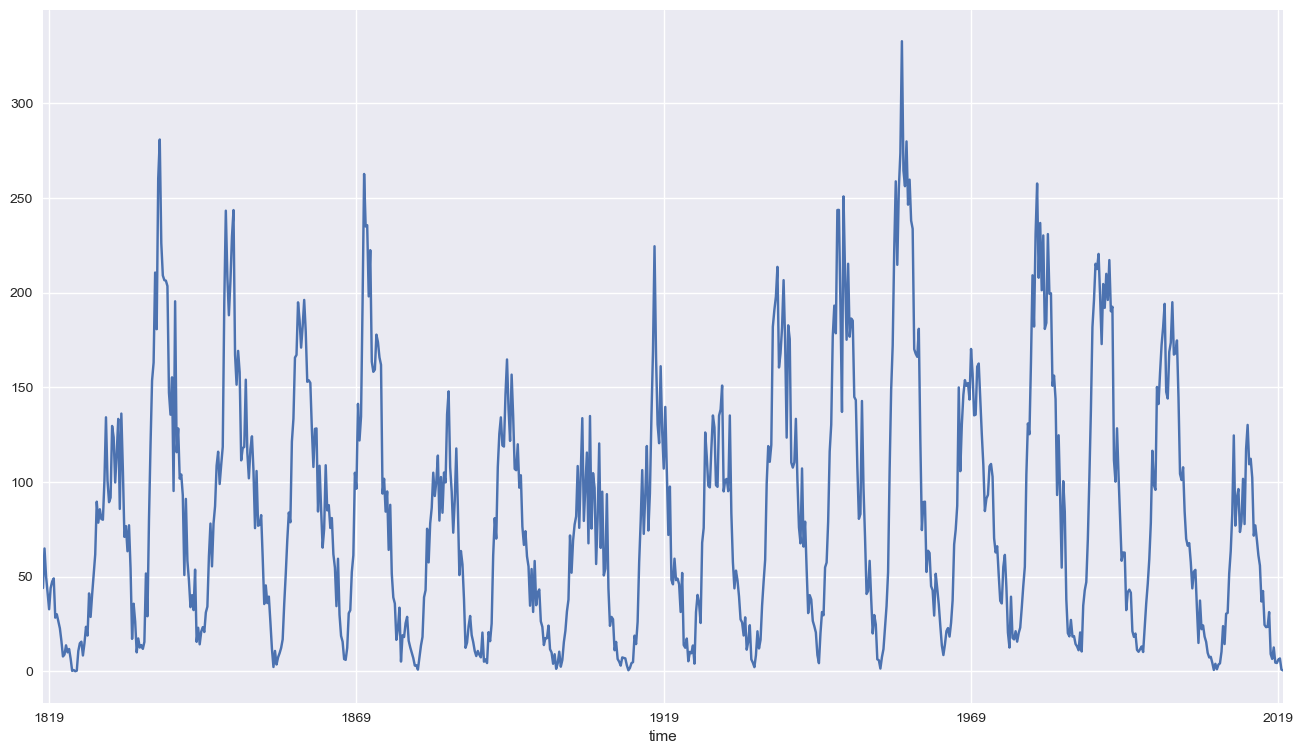

In [9]:
ts = pd.Series(data=df.sunspots, index=df.index)
#ts = ts['1900-01-01':]
ts_month = ts.resample('MS').mean()
ts_quarter = ts.resample('Q').mean()
ts_quarter.plot()
plt.show()

###  Plot PACF and ACF
PACF plot : order of the AR term (p) = first lag where the value is above the significance level. p=3

In [ ]:
plot_pacf(ts_quarter,lags=100,title='Sunspots')
plt.show()

ACF plot : q = first lag where the value is above the significance level. q=10

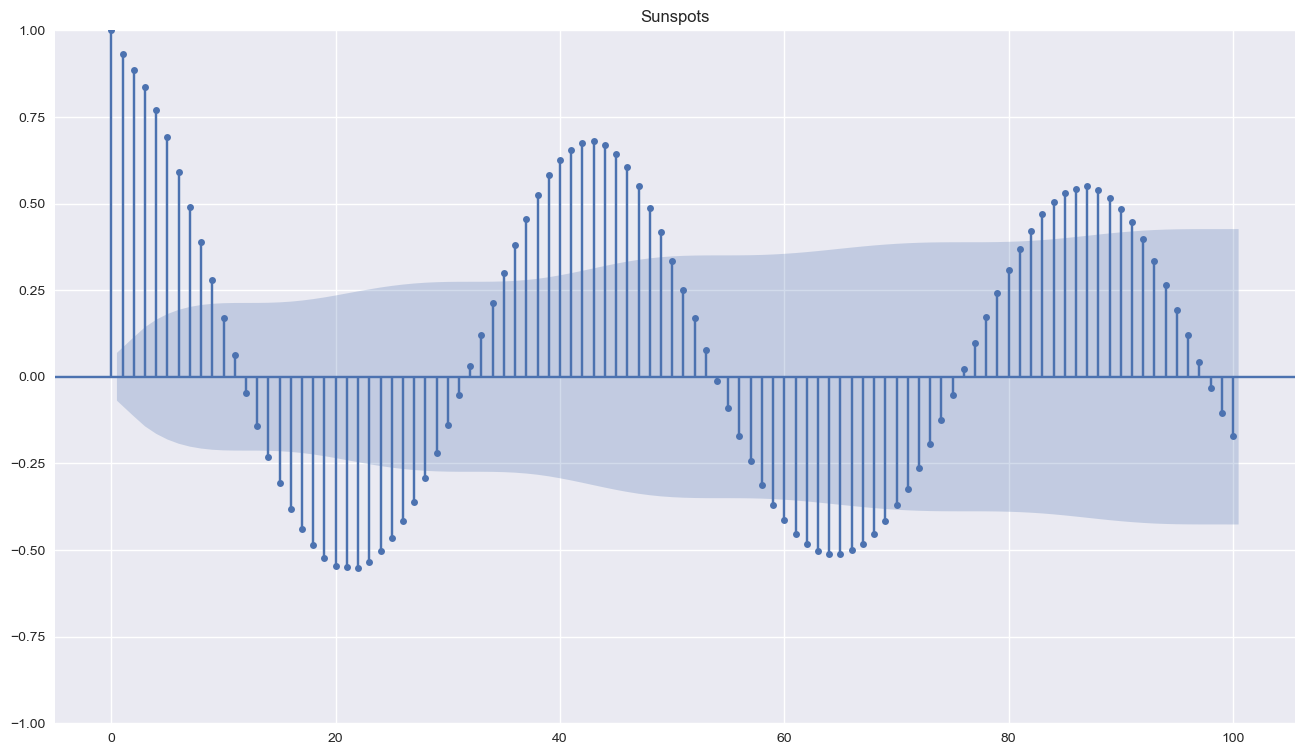

In [11]:
plot_acf(ts_quarter,lags=100,title='Sunspots')
plt.show()

### To Find the Order of Differencing (d)
D=1, the series has a stable seasonal pattern over time.

In [15]:
from statsmodels.tsa.stattools import adfuller
def printADFTest(serie):
    result = adfuller(serie, autolag='AIC')
    print("ADF Statistic %F" % (result[0]))
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print('\n')
    
printADFTest(ts_quarter)

ADF Statistic -9.778954
p-value: 6.814515890287899e-17
Critial Values:
   1%, -3.4385918508847646
Critial Values:
   5%, -2.865177791819505
Critial Values:
   10%, -2.568707096601096




### To Find the Seasonality (S)
From the ACF plot, the first high lag is around 42, so let's take S=42

### Build the model SARIMA(3,0,10)(1,1,0,42)

In [ ]:
model = sm.tsa.statespace.SARIMAX(ts_quarter, trend='n', order=(3,0,10), seasonal_order=(1,1,0,42))
results = model.fit()
print(results.summary())

### Plot the Forecast

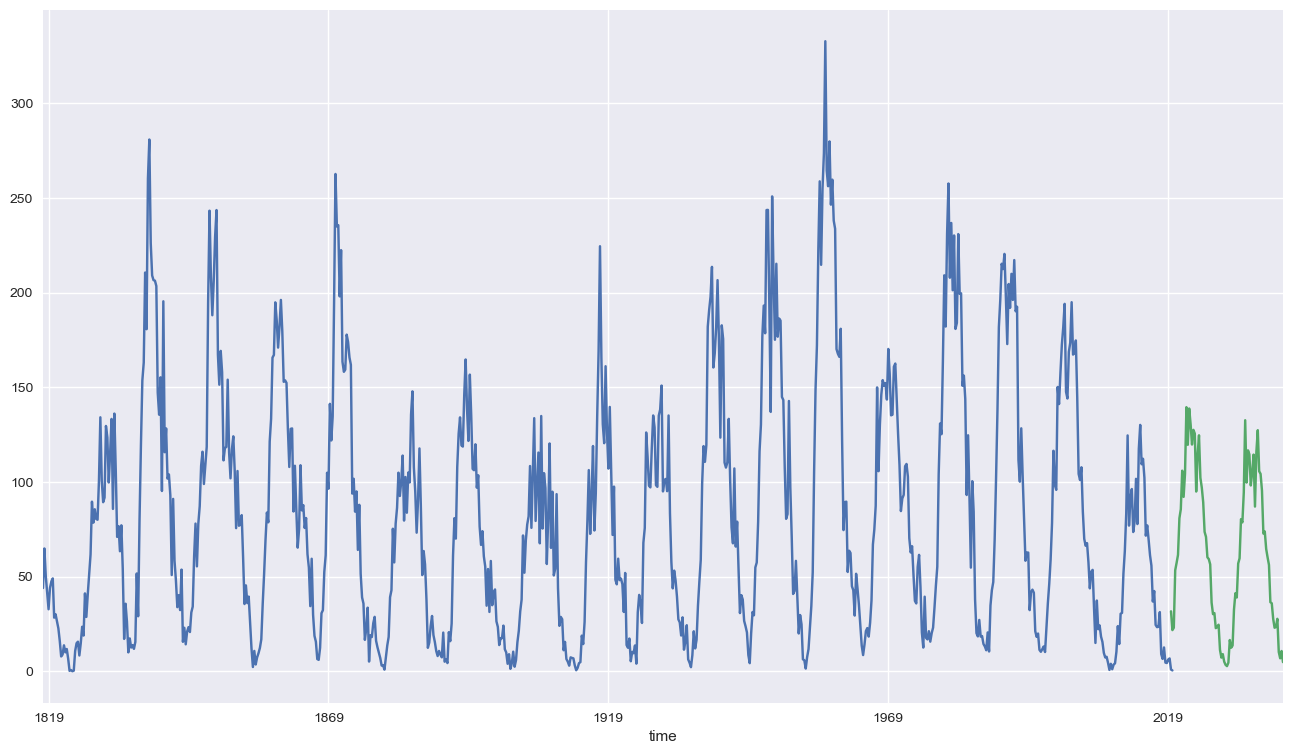

In [17]:
forecast = results.predict(start = ts_quarter.index[-2], end= ts_quarter.index[-2] + pd.DateOffset(months=240), dynamic= True) 
ts_quarter.plot()
forecast.plot()
plt.show()